In [1]:
# Set up the environment and define functions

# Import packages
import gc
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as op
import time
import pandas as pd
import glob
import csv
import mne
from mne.preprocessing.nirs import tddr
from nilearn.glm.first_level import make_first_level_design_matrix  
from mne_nirs.channels import get_long_channels
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_rel, zscore
import mne_nirs

mne.viz.set_browser_backend('matplotlib')

######### Set these variables as appropriate:
raw_path = '../../data'
proc_path = '../../processed'
results_path = '../../results'
subjects_dir = '../../subjects'
subject_group_mapping = pd.read_csv('../../subject_group_mapping.csv')
behavior_results_path = '../../fnirs-behavior-results'
behavior_file = '../../behavior_diff_data.csv'
output_suffix = "final" # used for all file names that are created

# Create the subject to group mapping dictionary
subject_group_mapping = subject_group_mapping.dropna(subset=['Subject'])  # Drop rows where 'Subject' is NA
subject_group_mapping['Subject'] = subject_group_mapping['Subject'].astype(int)  # Convert 'Subject' to integer
subject_to_group = dict(zip(subject_group_mapping['Subject'], subject_group_mapping['Group']))
subjects = subject_group_mapping['Subject'].astype(str).tolist()

sfreq = 4.807692
conditions = ('A', 'V', 'AV', 'W')
groups = ('trained', 'control')
days = ('1', '3')
runs = (1, 2)
duration = 1.8
design = 'event'
filt_kwargs = dict(l_freq=0.01, h_freq=0.2) 
n_jobs = 4  # for GLM

os.makedirs(proc_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(subjects_dir, exist_ok=True)
# mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # Only need to run once

use = None
all_sci = list()
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Prep making bad channels report
bad_channels_filename = op.join(results_path, f'bad_channels_report_{output_suffix}.csv')

with open(bad_channels_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Subject', 'Day', 'Run', 'Percent Bad'])

def add_bad_channel_entry(subject, day, run, percentage_bad):
    with open(bad_channels_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([subject, day, run, f'{percentage_bad:.2f}%'])

def normalize_channel_names(channels_set):
    return {name.split()[0] for name in channels_set}

# Sanity check for subjects
subjects_check = {int(subject) for subject in subjects}
subject_to_group_check = set(subject_to_group.keys())
if subjects_check == subject_to_group_check:
    print("N=" + str(len(subjects)))
    del subjects_check, subject_to_group_check
else:
    print("Error loading subject info") 

Using matplotlib as 2D backend.
N=29


In [2]:
# Set parameters for preprocessing

def preprocess_fnirs_data(raw_intensity, proc_path, base):
    # 1. Convert to optical density:
    print(f'    Run {base}')
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose='error')

    # 2. Identify bad channels based on flat signal and scalp coupling index:
    peaks = np.ptp(raw_od.get_data('fnirs'), axis=-1)
    flat_names = [raw_od.ch_names[f].split(' ')[0] for f in np.where(peaks < 0.001)[0]]
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    sci_mask = (sci < 0.25)
    got = np.where(sci_mask)[0]
    percentage_bad = (len(got) / len(raw_od.ch_names)) * 100
    assert raw_od.info['bads'] == []
    bads = set(raw_od.ch_names[pick] for pick in got)
    bads = bads | set(ch_name for ch_name in raw_od.ch_names if ch_name.split(' ')[0] in flat_names)
    bads = sorted(bads)

    # 3. Apply temporal derivative distribution repair (TDDR), bandpass filter, apply bad channels:
    raw_tddr = tddr(raw_od)
    raw_tddr_bp = raw_tddr.copy().filter(**filt_kwargs)
    raw_tddr_bp.info['bads'] = bads
    #raw_tddr_bp.info['bads'] = [] 

    # 5. Short channel regression (if present): 
    try:
        raw_tddr_bp = mne_nirs.signal_enhancement.short_channel_regression(raw_tddr_bp)
    except:
        print(f"No short channels found for {base}.")

    # 6. Convert to hemoglobin concentration:
    raw_h = mne.preprocessing.nirs.beer_lambert_law(raw_tddr_bp, 6.)

    # 7. Normalize channel names and verify bad channels
    h_bads = [ch_name for ch_name in raw_h.ch_names if ch_name.split(' ')[0] in set(bad.split(' ')[0] for bad in bads)]
    set_bads = set(bads)
    set_h_bads = set(h_bads)
    normalized_bads = normalize_channel_names(set_bads)
    normalized_h_bads = normalize_channel_names(set_h_bads)
    assert normalized_bads == normalized_h_bads
    raw_h.info['bads'] = h_bads
    raw_h.info._check_consistency()

    # 8. Select long channels and verify that the signal is not flat:
    raw_h = get_long_channels(raw_h)
    picks = mne.pick_types(raw_h.info, fnirs=True)
    peaks = np.ptp(raw_h.get_data(picks), axis=-1)
    assert (peaks > 1e-9).all()

    # 9. Interpolate bad channels
    raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))
    raw_h_interp.save(op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif'), overwrite=True)
    assert len(raw_h.ch_names) == len(raw_h_interp.ch_names)

    return raw_h_interp, percentage_bad, bads

In [3]:
# Load participant data

#subjects = ['223'] #testing

for subject in subjects:
    for day in days:
        for run in runs:
            group = subject_to_group.get(int(subject), "unknown")
            root1 = f'Day{day}'
            root2 = f'{subject}_{day}'
            root3 = f'*-*-*_{run:03d}'
            fname_base = op.join(raw_path, root1, root2, root3)
            fname = glob.glob(fname_base)
            base = f'{subject}_{day}_{run:03d}'
            base_pr = base.ljust(20)
            raw_intensity = mne.io.read_raw_nirx(fname[0])
            raw_intensity, percentage_bad_long, bads_long = preprocess_fnirs_data(raw_intensity, proc_path, base + '_long')
            add_bad_channel_entry(subject, day, run, percentage_bad_long)
            del raw_intensity, percentage_bad_long, bads_long
            gc.collect()  #


Loading ../../data/Day1/201_1/2023-09-21_001
    Run 201_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 201_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/201_1/2023-09-21_002
    Run 201_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 201_1_002_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/201_3/2023-09-23_001
    Run 201_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 201_3_001_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/201_3/2023-09-23_002
    Run 201_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/202_1/2023-10-03_001
    Run 202_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/202_1/2023-10-03_002
    Run 202_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/202_3/2023-10-05_001
    Run 202_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 202_3_001_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/202_3/2023-10-05_002
    Run 202_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 202_3_002_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/202_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/203_1/2023-10-06_001
    Run 203_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 203_1_001_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/203_1/2023-10-06_002
    Run 203_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 203_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/203_3/2023-10-08_001
    Run 203_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/203_3/2023-10-08_002
    Run 203_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/203_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/204_1/2023-10-07_001
    Run 204_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/204_1/2023-10-07_002
    Run 204_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 204_1_002_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/204_3/2023-10-09_001
    Run 204_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/204_3/2023-10-09_002
    Run 204_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/204_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/205_1/2023-10-13_001
    Run 205_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/205_1/2023-10-13_002
    Run 205_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 205_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/205_3/2023-10-15_001
    Run 205_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 205_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/205_3/2023-10-15_002
    Run 205_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 205_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/205_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/206_1/2023-10-14_001
    Run 206_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 206_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/206_1/2023-10-14_002
    Run 206_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 206_1_002_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/206_3/2023-10-16_001
    Run 206_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 206_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/206_3/2023-10-16_002
    Run 206_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 206_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/206_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/207_1/2023-10-17_001
    Run 207_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/207_1/2023-10-17_002
    Run 207_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/207_3/2023-10-19_001
    Run 207_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/207_3/2023-10-19_002
    Run 207_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 207_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/207_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/208_1/2023-10-23_001
    Run 208_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_1_001_long.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_001_long_hbo_final_raw.fif
[done]


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Loading ../../data/Day1/208_1/2023-10-23_002
    Run 208_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_002_long_hbo_final_raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/208_3/2023-10-25_001
    Run 208_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/208_3/2023-10-25_002
    Run 208_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 208_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/208_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/209_1/2023-10-26_001
    Run 209_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/209_1/2023-10-26_002
    Run 209_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/209_3/2023-10-28_001
    Run 209_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/209_3/2023-10-28_002
    Run 209_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 209_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/209_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/212_1/2023-11-07_001
    Run 212_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/212_1/2023-11-07_002
    Run 212_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/212_3/2023-11-09_001
    Run 212_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/212_3/2023-11-09_002
    Run 212_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 212_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/212_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/213_1/2023-12-04_001
    Run 213_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/213_1/2023-12-04_002
    Run 213_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/213_3/2023-12-06_001
    Run 213_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/213_3/2023-12-06_002
    Run 213_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 213_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/213_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/214_1/2023-11-04_001
    Run 214_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/214_1/2023-11-04_002
    Run 214_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/214_3/2023-11-06_001
    Run 214_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/214_3/2023-11-06_002
    Run 214_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 214_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/214_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/215_1/2023-12-11_001
    Run 215_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_1_001_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/215_1/2023-12-11_002
    Run 215_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/215_3/2023-12-13_001
    Run 215_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/215_3/2023-12-13_002
    Run 215_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 215_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/215_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/216_1/2024-01-13_001
    Run 216_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 216_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/216_1/2024-01-13_002
    Run 216_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 216_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/216_3/2024-01-16_001
    Run 216_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 216_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/216_3/2024-01-16_002
    Run 216_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 216_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/216_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/217_1/2024-01-10_001
    Run 217_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/217_1/2024-01-10_002
    Run 217_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/217_3/2024-01-12_001
    Run 217_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/217_3/2024-01-12_002
    Run 217_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 217_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/217_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/218_1/2024-01-26_001
    Run 218_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 218_1_001_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/218_1/2024-01-26_002
    Run 218_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 218_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/218_3/2024-01-28_001
    Run 218_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 218_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/218_3/2024-01-28_002
    Run 218_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 218_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/218_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/219_1/2024-01-29_001
    Run 219_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/219_1/2024-01-29_002
    Run 219_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/219_3/2024-01-31_001
    Run 219_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/219_3/2024-01-31_002
    Run 219_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 219_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/219_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/221_1/2024-02-03_001
    Run 221_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 221_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/221_1/2024-02-03_002
    Run 221_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 221_1_002_long.
Setting channel interpolation met

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/221_3/2024-02-05_001
    Run 221_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel interpolation method to {'fnirs': 'nearest'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/221_3/2024-02-05_002
    Run 221_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/221_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/223_1/2024-02-10_001
    Run 223_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/223_1/2024-02-10_002
    Run 223_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 223_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/223_3/2024-02-12_001
    Run 223_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 223_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/223_3/2024-02-12_002
    Run 223_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 223_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.6 mm
Overwriting existing file.
Writing /Users/ansle/D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/223_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/224_1/2024-02-10_001
    Run 224_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_1_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/224_1/2024-02-10_002
    Run 224_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_1_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/224_3/2024-02-12_001
    Run 224_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_3_001_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/224_3/2024-02-12_002
    Run 224_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

No short channels found for 224_3_002_long.
Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/224_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/225_1/2024-04-29_001
    Run 225_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel interpolation method to {'fnirs': 'nearest'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/225_1/2024-04-29_002
    Run 225_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/225_3/2024-05-01_001
    Run 225_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/225_3/2024-05-01_002
    Run 225_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/225_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/226_1/2024-04-30_001
    Run 226_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/226_1/2024-04-30_002
    Run 226_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/226_3/2024-05-02_001
    Run 226_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/226_3/2024-05-02_002
    Run 226_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/226_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/228_1/2024-06-10_001
    Run 228_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/228_1/2024-06-10_002
    Run 228_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/228_3/2024-06-12_001
    Run 228_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/228_3/2024-06-12_002
    Run 228_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/228_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/229_1/2024-06-26_001
    Run 229_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/229_1/2024-06-26_002
    Run 229_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/229_3/2024-06-28_001
    Run 229_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/229_3/2024-06-28_002
    Run 229_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/229_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/230_1/2024-06-26_001
    Run 230_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/230_1/2024-06-26_002
    Run 230_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/230_3/2024-06-28_001
    Run 230_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/230_3/2024-06-28_002
    Run 230_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/230_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/231_1/2024-07-01_001
    Run 231_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/231_1/2024-07-01_002
    Run 231_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/231_3/2024-07-03_001
    Run 231_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/231_3/2024-07-03_002
    Run 231_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/231_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/232_1/2024-07-27_001
    Run 232_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/232_1/2024-07-27_002
    Run 232_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/232_3/2024-07-29_001
    Run 232_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/232_3/2024-07-29_002
    Run 232_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/232_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/233_1/2024-07-14_001
    Run 233_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/233_1/2024-07-14_002
    Run 233_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel interpolatio

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/233_3/2024-07-16_001
    Run 233_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel interpolatio

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/233_3/2024-07-16_002
    Run 233_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)

Setting channel interpolation method to {'fnirs': 'nearest'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/233_3_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/234_1/2024-07-01_001
    Run 234_1_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day1/234_1/2024-07-01_002
    Run 234_1_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.7 mm
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_1_002_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/234_3/2024-07-04_001
    Run 234_3_001_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_001_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_001_long_hbo_final_raw.fif
[done]
Loading ../../data/Day3/234_3/2024-07-04_002


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


    Run 234_3_002_long
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 1587 samples (330.096 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Setting channel interpolation method to {'fnirs': 'nearest'}.
Overwriting existing file.
Writing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_002_long_hbo_final_raw.fif
Closing /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/234_3_002_long_hbo_final_raw.fif
[done]


/var/folders/dv/s4k5_3r51ml3q36bgbcdsgbr0000gn/T/ipykernel_98322/1797672691.py:52: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_h_interp = raw_h.copy().interpolate_bads(reset_bads=True, method=dict(fnirs='nearest'))


In [4]:
# Remove subjects with >30% bad channels 

bad_channels_df = pd.read_csv(bad_channels_filename)
bad_channels_df['Percent Bad'] = bad_channels_df['Percent Bad'].str.rstrip('%').astype(float)
average_bad_channels = bad_channels_df.groupby('Subject')['Percent Bad'].mean()

# Find subjects with more than 30% bad channels
bad_subjects = average_bad_channels[average_bad_channels > 30].index.tolist()
print("Subjects with more than 30% bad channels:", bad_subjects)

# Initialize counters for each group
removed_trained = 0
removed_control = 0
remaining_trained = 0
remaining_control = 0

# Count and remove the subjects
for subject in bad_subjects:
    subject_int = int(subject) 
    if subject_int in subject_to_group:
        if subject_to_group[subject_int] == "trained":
            removed_trained += 1
        elif subject_to_group[subject_int] == "control":
            removed_control += 1
        subject_to_group.pop(subject_int, None)

# Update the subjects list after counting the removed subjects
subjects = [subject for subject in subjects if subject not in bad_subjects]
for group in subject_to_group.values():
    if group == "trained":
        remaining_trained += 1
    elif group == "control":
        remaining_control += 1

# Output the results
print(" ")
print(f'Removed {removed_trained} trained subjects.')
print(f'Removed {removed_control} control subjects.')
print(" ")
print(f'Remaining trained subjects: {remaining_trained}')
print(f'Remaining control subjects: {remaining_control}')

Subjects with more than 30% bad channels: [202, 203, 204, 206, 214, 221, 223, 226, 233]
 
Removed 5 trained subjects.
Removed 4 control subjects.
 
Remaining trained subjects: 10
Remaining control subjects: 10


In [5]:
# Clean events and make design matrix

def make_design(raw_h_long, design, subject=None, run=None, day=None, group=None):
    annotations_to_remove = raw_h_long.annotations.description == '255.0'
    raw_h_long.annotations.delete(annotations_to_remove)
    events, _ = mne.events_from_annotations(raw_h_long)
    
    # Fix mis-codings
    rows_to_remove = events[:, -1] == 1
    events = events[~rows_to_remove]
    if len(events) == 101:
        events = events[1:]
        
    n_times = len(raw_h_long.times)
    stim = np.zeros((n_times, 4))
    events[:, 2] -= 1
    assert len(events) == 100, len(events)
    want = [0] + [25] * 4
    count = np.bincount(events[:, 2])
    assert np.array_equal(count, want), count
    assert events.shape == (100, 3), events.shape

    if design == 'block':
        events = events[0::5]
        duration = 20.
        assert np.array_equal(np.bincount(events[:, 2]), [0] + [5] * 4)
    else:
#        assert design == 'event'
        assert len(events) == 100
        duration = 1.8
        assert events.shape == (100, 3)
        events_r = events[:, 2].reshape(20, 5)
        assert (events_r == events_r[:, :1]).all()
        del events_r
        
    idx = (events[:, [0, 2]] - [0, 1]).T
    assert np.in1d(idx[1], np.arange(len(conditions))).all()
    stim[tuple(idx)] = 1
    
    n_block = int(np.ceil(duration * sfreq))
    stim = signal.fftconvolve(stim, np.ones((n_block, 1)), axes=0)[:n_times]
    dm_events = pd.DataFrame({
        'trial_type': [conditions[ii] for ii in idx[1]],
        'onset': idx[0] / raw_h_long.info['sfreq'],
        'duration': n_block / raw_h_long.info['sfreq']})
    dm = make_first_level_design_matrix(
        raw_h_long.times, dm_events, hrf_model='glover',
        drift_model='polynomial', drift_order=0)
        
    return stim, dm, events


Opening raw data file ../../processed/223_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 3937 =      0.000 ...   818.896 secs
Ready.
Reading 0 ... 3937  =      0.000 ...   818.896 secs...
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']


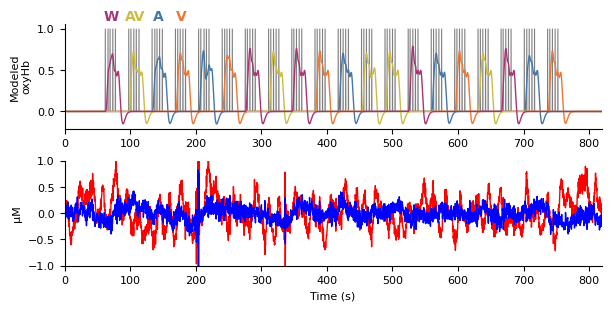

In [6]:
# Change the subject, day, and run to plot different waveforms
plot_subject = '223'
plot_day = 1
plot_run = 1

fname2 = op.join(proc_path, f'{plot_subject}_{plot_day}_{plot_run:03d}_long_hbo_{output_suffix}_raw.fif')
use = mne.io.read_raw_fif(fname2, preload=True)
events, _ = mne.events_from_annotations(use)
ch_names = [ch_name.rstrip(' hbo') for ch_name in use.ch_names]
info = use.info

fig, axes = plt.subplots(2, 1, figsize=(6., 3), constrained_layout=True)
ax = axes[0]
raw_h = use
stim, dm, _ = make_design(raw_h, design)

colors = dict(
    A='#4477AA',  # blue
    AV='#CCBB44',  # yellow
    V='#EE7733',  # orange
    W='#AA3377',  # purple
)

for ci, condition in enumerate(conditions):
    color = colors[condition]
    ax.fill_between(
        raw_h.times, stim[:, ci], 0, edgecolor='none', facecolor='k',
        alpha=0.5)
    model = dm[conditions[ci]].to_numpy()
    ax.plot(raw_h.times, model, ls='-', lw=1, color=color)
    x = raw_h.times[np.where(model > 0)[0][0]]
    ax.text(
        x + 10, 1.1, condition, color=color, fontweight='bold', ha='center')
ax.set(ylabel='Modeled\noxyHb', xlabel='', xlim=raw_h.times[[0, -1]])

# HbO/HbR
ax = axes[1]
picks = [pi for pi, ch_name in enumerate(raw_h.ch_names)
         if 'S7_D19' in ch_name]
colors = dict(hbo='r', hbr='b')
ylim = np.array([-1, 1])
for pi, pick in enumerate(picks):
    color = colors[raw_h.ch_names[pick][-3:]]
    data = raw_h.get_data(pick)[0] * 1e6
    val = np.ptp(data)
    assert val > 0.01
    ax.plot(raw_h.times, data, color=color, lw=1.)
ax.set(ylim=ylim, xlabel='Time (s)', ylabel='μM',
       xlim=raw_h.times[[0, -1]])
for ax in axes:
    for key in ('top', 'right'):
        ax.spines[key].set_visible(False)
plt.savefig(op.join(results_path, f'figure_1_{output_suffix}.png'))


In [7]:
# Run GLM analysis and epoching
subj_cha_list = []
for subject in subjects:
    group = subject_to_group.get(int(subject), "unknown")
    for day in days:
        for run in runs:
            fname_long = op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif')
            raw_h_long = mne.io.read_raw_fif(fname_long)
            _, dm, _ = make_design(raw_h_long, design, subject, run, day, group)
            glm_est = mne_nirs.statistics.run_glm(
                raw_h_long, dm, noise_model='ols', n_jobs=n_jobs)
            cha = glm_est.to_dataframe()
            cha['subject'] = subject
            cha['run'] = run
            cha['day'] = day
            cha['group'] = group
            subj_cha_list.append(cha)
            del raw_h_long, dm, glm_est, cha
            gc.collect()  #
        print(f'***Finished processing subject {subject} day {day}.')

df_cha = pd.concat(subj_cha_list, ignore_index=True)
df_cha.reset_index(drop=True, inplace=True)


Opening raw data file ../../processed/201_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 3994 =      0.000 ...   830.752 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Opening raw data file ../../processed/201_1_002_long_hbo_final_raw.fif...
    Range : 0 ... 3838 =      0.000 ...   798.304 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
***Finished processing subject 201 day 1.
Opening raw data file ../../processed/201_3_001_long_hbo_final_raw.fif...
    Range : 0 ... 3945 =      0.000 ...   820.560 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Opening raw data file ../../processed/201_3_002_long_hbo_final_raw.fif...
    Range : 0 ... 3945 =      0.000 ...   820.560 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
***Finished processing subject 201 day 3.
Opening raw data file ../../processed/202_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 3946 =      

In [8]:
# Block averages
event_id = {condition: ci for ci, condition in enumerate(conditions, 1)}
evokeds = {condition: dict() for condition in conditions}
for day in days:
    for subject in subjects:
        fname = op.join(proc_path, f'{subject}_{day}_{output_suffix}-ave.fif')
        tmin, tmax = -2, 38
        baseline = (None, 0)
        t0 = time.time()
        print(f'Creating block average for {subject} day {day}... ', end='')
        raws = list()
        events = list()
        for run in runs:
            fname2 = op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif')
            raw_h = mne.io.read_raw_fif(fname2)
            events.append(make_design(raw_h, None, 'block', subject, run)[2])
            raws.append(raw_h)
        bads = sorted(set(sum((r.info['bads'] for r in raws), [])))
        for r in raws:
            r.info['bads'] = bads
        raw_h, events = mne.concatenate_raws(raws, events_list=events)
        epochs = mne.Epochs(raw_h, events, event_id, tmin=tmin, tmax=tmax,
                            baseline=baseline)
        this_ev = [epochs[condition].average() for condition in conditions]
        assert all(ev.nave > 0 for ev in this_ev)
        mne.write_evokeds(fname, this_ev, overwrite=True)
        print(f'{time.time() - t0:0.1f} sec')
        for condition in conditions:
            evokeds[condition][subject] = mne.read_evokeds(fname, condition)
        print(f'Done for {group} {subject} day {day} run {run:03d}... ', end='')
        del raws, events, raw_h, epochs, this_ev
        gc.collect()  #

# Mark bad channels
bad = dict()
bb = dict()

for day in days:
    for subject in subjects:
        for run in runs:
            fname2 = op.join(proc_path, f'{subject}_{day}_{run:03d}_long_hbo_{output_suffix}_raw.fif')
            this_info = mne.io.read_info(fname2)
            bad_channels = [idx - 1 for idx in sorted(
                this_info['ch_names'].index(bad) + 1 for bad in this_info['bads'])]
            valid_indices = np.arange(len(use.ch_names))
            bb = [b for b in bad_channels if b in valid_indices]
            bad[(subject, run, day)] = bb
        assert np.in1d(bad[(subject, run, day)], np.arange(len(use.ch_names))).all()

bad_combo = dict()
for day in days:
    for (subject, run, day), bb in bad.items():
        bad_combo[subject] = sorted(set(bad_combo.get(subject, [])) | set(bb))
bad = bad_combo

start = len(df_cha)
n_drop = 0
for day in days:
    for (subject, run, day), bb in bad.items():
        if not len(bb):
            continue
        drop_names = [use.ch_names[b] for b in bb]
        is_subject = (df_cha['subject'] == subject)
        is_day = (df_cha['day'] == day)
        drop = df_cha.index[
            is_subject &
            is_day &
            np.in1d(df_cha['ch_name'], drop_names)]
        n_drop += len(drop)
        if len(drop):
            print(f'Dropping {len(drop)} for {subject} day {day}')
            df_cha.drop(drop, inplace=True)
end = len(df_cha)
assert n_drop == start - end, (n_drop, start - end)

# Combine runs by averaging
sorts = ['subject', 'ch_name', 'Chroma', 'Condition', 'group', 'day', 'run']
df_cha.sort_values(sorts, inplace=True)
theta = np.array(df_cha['theta']).reshape(-1, len(runs)).mean(-1)
df_cha.drop(
    [col for col in df_cha.columns if col not in sorts[:-1]], axis='columns',
    inplace=True)
df_cha.reset_index(drop=True, inplace=True)
df_cha = df_cha[::len(runs)]
df_cha.reset_index(drop=True, inplace=True)
df_cha['theta'] = theta

Creating block average for 201 day 1... Opening raw data file ../../processed/201_1_001_long_hbo_final_raw.fif...
    Range : 0 ... 3994 =      0.000 ...   830.752 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Opening raw data file ../../processed/201_1_002_long_hbo_final_raw.fif...
    Range : 0 ... 3838 =      0.000 ...   798.304 secs
Ready.
Used Annotations descriptions: ['1.0', '2.0', '3.0', '4.0', '5.0']
Not setting metadata
200 matching events found
Setting baseline interval to [-2.0800001110839905, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Overwriting existing file.
3.5 sec
Reading /Users/ansle/Documents/GitHub/fnirs-analysis/GithubCode/fnirs-analysis/../../processed/201_1_final-ave.fif ...
    Found the data of interest:
        t =   -2080.00 ...   38064.00 ms (A)
        0 CTF compensation matrices available
        nave = 50 - aspect type = 100
No projector specified for this dataset. Please consider the me

In [9]:
# CALCULATE HbDIFF

# Load the data
df_cha_nolabels = df_cha.copy()
df_cha_nolabels['ch_name'] = df_cha_nolabels['ch_name'].str[:-4]

# Separate HbO and HbR
df_hbo = df_cha_nolabels[df_cha_nolabels['Chroma'].str.endswith('hbo')].set_index(['subject', 'Condition', 'group', 'day', 'ch_name']).sort_index()
df_hbr = df_cha_nolabels[df_cha_nolabels['Chroma'].str.endswith('hbr')].set_index(['subject', 'Condition', 'group', 'day', 'ch_name']).sort_index()

# Compute the difference
df_cha_diff_list = []
for ch_name in df_hbo.index.get_level_values('ch_name').unique():
    # Get aligned indices
    df_hbo_ch = df_hbo.loc[(slice(None), slice(None), slice(None), slice(None), ch_name), :].sort_index()
    df_hbr_ch = df_hbr.loc[(slice(None), slice(None), slice(None), slice(None), ch_name), :].sort_index()
    
    # Ensure df_hbo_ch and df_hbr_ch have the same length
    common_index = df_hbo_ch.index.intersection(df_hbr_ch.index)
    df_hbo_ch = df_hbo_ch.loc[common_index]
    df_hbr_ch = df_hbr_ch.loc[common_index]
    
    # Calculate the difference
    df_diff = df_hbo_ch[['theta']].sub(df_hbr_ch[['theta']])
    
    # Align df_cha_ch with df_diff
    df_cha_ch = df_hbo_ch.reset_index()
    df_cha_ch['theta'] = df_diff.values
    df_cha_ch['Chroma'] = 'hbdiff'
    df_cha_ch['ch_name'] = df_cha_ch['ch_name'] + ' hbdiff'
    
    if not df_cha_ch.empty:
        df_cha_diff_list.append(df_cha_ch)

df_cha_diff_concat = pd.concat(df_cha_diff_list, ignore_index=True)

# Concatenate original df_cha with df_cha_diff_concat
df_final = pd.concat([df_cha, df_cha_diff_concat], ignore_index=True)
df_final.to_csv(op.join(results_path, f'df_combined_final_cha_{output_suffix}.csv'), index=False)


In [ ]:
# Analyze changes in fNIRS data and behavior
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning) # type: ignore

# Load the datasets
behavior_df = pd.read_csv(behavior_file)
behavior_df['subject'] = behavior_df['subject'].astype(str)
theta_df = df_final.copy()
theta_df['subject'] = theta_df['subject'].astype(str)

# Get the unique conditions
conditions = ['A', 'AV', 'V']
response_vars = ['AO_WR', 'AV_WR', 'TBW']
chromas = ['hbo', 'hbr', 'hbdiff']
days = ['1', '3']

def perform_analysis(group, output_suffix):
    # Initialize a list to store significant models
    significant_models = []
    
    # Initialize a dictionary to store p-values and model data by condition, response variable, chroma, and day
    all_p_values = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}
    all_model_data = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}

    # Track maximum R-squared value
    max_r_squared = 0
    max_r_squared_model = None

    for day in days:
        theta_df_filtered = theta_df[theta_df['day'] == day].copy()
        theta_df_filtered['ch_name'] = theta_df_filtered['ch_name'].str.split(' ').str[0]

        for chroma in chromas:
            # Filter theta_df for the specific chroma
            theta_dataset = theta_df_filtered[theta_df_filtered['Chroma'] == chroma].copy()
            theta_dataset['ch_name'] = theta_dataset['ch_name'].str.split(' ').str[0]

            # Collect all p-values and model data for each response variable and condition
            for condition in conditions:
                for response_var in response_vars:
                    # Filter the dataset for the current condition
                    theta_df_condition = theta_dataset[theta_dataset['Condition'] == condition]
                    
                    # Pivot the theta_df to have channel names as columns
                    theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group', 'Condition'], columns='ch_name', values='theta').reset_index()
                    theta_pivot['subject'] = theta_pivot['subject'].astype(str)  # Ensure subject is string

                    # Merge the datasets based on 'subject' and 'group'
                    merged_df = pd.merge(theta_pivot, behavior_df[['subject', 'group', 'TBW', 'AO_WR', 'AV_WR', 'VO_WR', 'age', 'AO_WR_1', 'AV_WR_1', 'VO_WR_1', 'TBW_1']], on=['subject', 'group'])
                    channels = theta_df_condition['ch_name'].unique()  # list of all channel names

                    for channel in channels:
                        df = merged_df[[channel, response_var, 'group']].dropna()  # drop rows with missing values
                        if df.empty:
                            continue  # Skip this channel if there is no data
                        model = smf.ols(f"{response_var} ~ {channel}", df[df['group'] == group]).fit()
                        r_sq = model.rsquared
                        p_value_channel = model.pvalues[channel]  # p-value for the channel
                        all_p_values[condition][response_var][chroma][day].append(p_value_channel)
                        all_model_data[condition][response_var][chroma][day].append((condition, channel, response_var, model, r_sq, p_value_channel, df, chroma, day))

                    p_values = all_p_values[condition][response_var][chroma][day]
                    model_data = all_model_data[condition][response_var][chroma][day]
                    
                    if p_values:
                        # Apply FDR correction
                        rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
                        
                        # Filter results based on FDR corrected p-values
                        for (condition, channel, response_var, model, r_sq, p_value, df, chroma, day), p_val_corr, reject in zip(model_data, p_values_corrected, rejected):
                            sig_count = 0
                            if p_val_corr < 0.05:
                                sig_count = +1
                                significant_models.append({
                                    'Condition': condition,
                                    'Channel': channel,
                                    'Response Variable': response_var,
                                    'R-squared': r_sq,
                                    'P-value': p_value,
                                    'P-value Corrected': p_val_corr,
                                    'Model Summary': model.summary().as_text(),
                                    'Chroma': chroma,
                                    'Day': day
                                })

                                # Plot the significant results
                                plt.figure(figsize=(8, 6))

                                # Plot trained data
                                trained_df = df[df['group'] == 'trained']
                                if not trained_df.empty:
                                    trained_model = smf.ols(f"{response_var} ~ {channel}", trained_df).fit()
                                    sns.scatterplot(x=trained_df[channel], y=trained_df[response_var], label='Trained', color='#92b6f0', s=100)
                                    sns.lineplot(x=trained_df[channel], y=trained_model.predict(trained_df), color='#92b6f0', linewidth=2)

                                # Plot control data
                                control_df = df[df['group'] == 'control']
                                if not control_df.empty:
                                    control_model = smf.ols(f"{response_var} ~ {channel}", control_df).fit()
                                    sns.scatterplot(x=control_df[channel], y=control_df[response_var], label='Control', color='gray', s=100)
                                    sns.lineplot(x=control_df[channel], y=control_model.predict(control_df), color='gray', linewidth=2)
                                
                                xlabel = ('[HbO] on Day ' + str(day) if chroma == 'hbo' else
                                        '[HbR] on Day ' + str(day) if chroma == 'hbr' else
                                        '[HbDiff] on Day ' + str(day) if chroma == 'hbdiff' else
                                        f'{chroma.upper()} on Day ' + str(day))
                                ylabel = ('Change in Auditory Word Recognition' if response_var == 'AO_WR' else
                                        'Change in Audiovisual Word Recognition' if response_var == 'AV_WR' else
                                        'Change in Visual Word Recognition' if response_var == 'VO_WR' else
                                        f'Change in {response_var}')
                                plt.legend(loc='upper right') 
                                plt.xlabel(xlabel, fontsize=16)
                                plt.ylabel(ylabel, fontsize=16)
                                plt.title(f'{ylabel} vs.\nCortical Response to {condition} Speech ({channel})', fontsize=16)
                                plt.savefig(op.join(results_path, f'{condition}_{channel}_{response_var}_plot_{chroma}_day{day}_{output_suffix}.png'))
                                plt.show()
                                
    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        significant_models_df.to_csv(op.join(results_path, f'{group}_fnirs-behavior-models_{output_suffix}.csv'), index=False)
    else:
        print("    No significant models found for the " + group + " group.")

# Perform analysis for the trained group
perform_analysis('trained', 'trained')

# Perform analysis for the control group
perform_analysis('control', 'control')


In [27]:
# Run same analysis but with change in theta values

# Load the datasets
behavior_df = pd.read_csv(behavior_file)
behavior_df['subject'] = behavior_df['subject'].astype(str)
theta_df = df_final.copy()
theta_df['subject'] = theta_df['subject'].astype(str)

# Get the unique conditions
conditions = ['A', 'AV', 'V']
response_vars = ['AO_WR', 'AV_WR', 'TBW']
chromas = ['hbo', 'hbr', 'hbdiff']
days = ['1', '3']

theta_df_filtered = theta_df.pivot_table(index=['subject', 'group', 'Condition', 'Chroma', 'ch_name'], columns='day', values='theta').reset_index()
theta_df_filtered['theta_diff'] = theta_df_filtered['3'] - theta_df_filtered['1']
output_suffix = "theta_diff_final"

def perform_analysis(group, output_suffix):
    # Initialize a list to store significant models
    significant_models = []
    
    # Initialize a dictionary to store p-values and model data by condition, response variable, chroma, and day
    all_p_values = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}
    all_model_data = {condition: {response_var: {chroma: {day: [] for day in days} for chroma in chromas} for response_var in response_vars} for condition in conditions}

    # Track maximum R-squared value
    max_r_squared = 0
    max_r_squared_model = None

    for day in days:
        theta_df_filtered = theta_df[theta_df['day'] == day].copy()
        theta_df_filtered['ch_name'] = theta_df_filtered['ch_name'].str.split(' ').str[0]

        for chroma in chromas:
            # Filter theta_df for the specific chroma
            theta_dataset = theta_df_filtered[theta_df_filtered['Chroma'] == chroma].copy()
            theta_dataset['ch_name'] = theta_dataset['ch_name'].str.split(' ').str[0]

            # Collect all p-values and model data for each response variable and condition
            for condition in conditions:
                for response_var in response_vars:
                    # Filter the dataset for the current condition
                    theta_df_condition = theta_dataset[theta_dataset['Condition'] == condition]
                    
                    # Pivot the theta_df to have channel names as columns
                    theta_pivot = theta_df_condition.pivot_table(index=['subject', 'group', 'Condition'], columns='ch_name', values='theta_diff').reset_index()
                    theta_pivot['subject'] = theta_pivot['subject'].astype(str)  # Ensure subject is string

                    # Merge the datasets based on 'subject' and 'group'
                    merged_df = pd.merge(theta_pivot, behavior_df[['subject', 'group', 'TBW', 'AO_WR', 'AV_WR', 'VO_WR', 'age', 'AO_WR_1', 'AV_WR_1', 'VO_WR_1', 'TBW_1']], on=['subject', 'group'])
                    channels = theta_df_condition['ch_name'].unique()  # list of all channel names

                    for channel in channels:
                        df = merged_df[[channel, response_var, 'group']].dropna()  # drop rows with missing values
                        if df.empty:
                            continue  # Skip this channel if there is no data
                        model = smf.ols(f"{response_var} ~ {channel}", df[df['group'] == group]).fit()
                        r_sq = model.rsquared
                        p_value_channel = model.pvalues[channel]  # p-value for the channel
                        all_p_values[condition][response_var][chroma][day].append(p_value_channel)
                        all_model_data[condition][response_var][chroma][day].append((condition, channel, response_var, model, r_sq, p_value_channel, df, chroma, day))

                    p_values = all_p_values[condition][response_var][chroma][day]
                    model_data = all_model_data[condition][response_var][chroma][day]
                    
                    if p_values:
                        # Apply FDR correction
                        rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
                        
                        # Filter results based on FDR corrected p-values
                        for (condition, channel, response_var, model, r_sq, p_value, df, chroma, day), p_val_corr, reject in zip(model_data, p_values_corrected, rejected):
                            sig_count = 0
                            if p_val_corr < 0.05:
                                sig_count = +1
                                significant_models.append({
                                    'Condition': condition,
                                    'Channel': channel,
                                    'Response Variable': response_var,
                                    'R-squared': r_sq,
                                    'P-value': p_value,
                                    'P-value Corrected': p_val_corr,
                                    'Model Summary': model.summary().as_text(),
                                    'Chroma': chroma,
                                    'Day': day
                                })

                                # Plot the significant results
                                plt.figure(figsize=(8, 6))

                                # Plot trained data
                                trained_df = df[df['group'] == 'trained']
                                if not trained_df.empty:
                                    trained_model = smf.ols(f"{response_var} ~ {channel}", trained_df).fit()
                                    sns.scatterplot(x=trained_df[channel], y=trained_df[response_var], label='Trained', color='#92b6f0', s=100)
                                    sns.lineplot(x=trained_df[channel], y=trained_model.predict(trained_df), color='#92b6f0', linewidth=2)

                                # Plot control data
                                control_df = df[df['group'] == 'control']
                                if not control_df.empty:
                                    control_model = smf.ols(f"{response_var} ~ {channel}", control_df).fit()
                                    sns.scatterplot(x=control_df[channel], y=control_df[response_var], label='Control', color='gray', s=100)
                                    sns.lineplot(x=control_df[channel], y=control_model.predict(control_df), color='gray', linewidth=2)
                                
                                xlabel = f'{chroma.upper()} Change (Day 3 - Day 1) on {channel}'
                                ylabel = ('Change in Auditory Word Recognition' if response_var == 'AO_WR' else
                                        'Change in Audiovisual Word Recognition' if response_var == 'AV_WR' else
                                        'Change in Visual Word Recognition' if response_var == 'VO_WR' else
                                        f'Change in {response_var}')
                                plt.legend(loc='upper right') 
                                plt.xlabel(xlabel, fontsize=16)
                                plt.ylabel(ylabel, fontsize=16)
                                plt.title(f'{ylabel} vs.\nCortical Response to {condition} Speech ({channel})', fontsize=16)
                                plt.savefig(op.join(results_path, f'{condition}_{channel}_{response_var}_plot_{chroma}_change_{output_suffix}.png'))
                                plt.show()
                                
    if significant_models:
        significant_models_df = pd.DataFrame(significant_models).sort_values(by='R-squared', ascending=False)
        significant_models_df.to_csv(op.join(results_path, f'{group}_fnirs-behavior-models_change_{output_suffix}.csv'), index=False)
    else:
        print("No significant models found for the " + group + " group.")

# Perform analysis for the trained group
perform_analysis('trained', 'trained')

# Perform analysis for the control group
perform_analysis('control', 'control')


KeyError: 'theta_diff'

In [ ]:
merged_df

NameError: name 'merged_df' is not defined

Code below is still in progress...

In [ ]:
""" # Run paired t-test over days and plot changes over time

# Load the final combined dataframe
df_final = pd.read_csv(op.join(results_path, f'df_combined_final_cha_{output_suffix}.csv'))
conditions = ['A', 'AV', 'V']
groups = ['trained', 'control']
chromas = ['hbo', 'hbr', 'hbdiff']

df_final['ch_name'] = df_final['ch_name'].str.split(' ').str[0]
fname = op.join(proc_path, f'205_1_001_long_hbo_final_raw.fif')
use = mne.io.read_raw_fif(fname, preload=True)
use.load_data()
new_ch_names = {}
seen_names = set()
for ch_name in use.info['ch_names']:
    new_name = ch_name.split(' ')[0]
    if new_name not in seen_names:
        new_ch_names[ch_name] = new_name
        seen_names.add(new_name)

use.rename_channels(new_ch_names)
use = use.pick_channels(list(new_ch_names.values()))

# Perform analysis for each group and Chroma
for group in groups:
    for chroma in chromas:
        # Prepare figure for composite plots
        fig, axes = plt.subplots(1, len(conditions), figsize=(15, 5))
        for idx, condition in enumerate(conditions):
            # Filter data for day 1 and day 3 for the specific group and Chroma
            df_day1 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 1").copy()
            df_day3 = df_final.query(f"group == '{group}' and Chroma == '{chroma}' and day == 3").copy()

            # Ensure ch_name and Condition columns are of the same data type
            df_day1['ch_name'] = df_day1['ch_name'].astype(str)
            df_day1['Condition'] = df_day1['Condition'].astype(str)
            df_day3['ch_name'] = df_day3['ch_name'].astype(str)
            df_day3['Condition'] = df_day3['Condition'].astype(str)

            # Set index and sort
            df_day1 = df_day1.set_index(['subject', 'group', 'ch_name', 'Condition', 'Chroma']).sort_index()
            df_day3 = df_day3.set_index(['subject', 'group', 'ch_name', 'Condition', 'Chroma']).sort_index()

            # Merge dataframes to align day 1 and day 3 data
            df_merged = df_day1[['theta']].rename(columns={'theta': 'theta_day1'}).merge(
                df_day3[['theta']].rename(columns={'theta': 'theta_day3'}),
                left_index=True, right_index=True)

            # Calculate the difference and z-score
            df_merged['theta_diff'] = df_merged['theta_day3'] - df_merged['theta_day1']
            df_merged['z'] = zscore(df_merged['theta_diff'])

            # Perform paired t-test for each channel and condition across subjects
            t_stats = []
            p_values = []
            ch_names = []
            condition_list = []

            for (ch_name, cond), group_df in df_merged.groupby(['ch_name', 'Condition']):
                t_stat, p_value = ttest_rel(group_df['theta_day1'], group_df['theta_day3'])
                t_stats.append(t_stat)
                p_values.append(p_value)
                ch_names.append(ch_name)
                condition_list.append(cond)

            # Create a results DataFrame
            results_df = pd.DataFrame({
                'ch_name': ch_names,
                'Condition': condition_list,
                't_stat': t_stats,
                'p_value': p_values
            })

            # Combine with z-score data
            z_scores = df_merged.groupby(['ch_name', 'Condition'])['z'].mean().reset_index()
            
            # Ensure consistent data types before merging
            z_scores['ch_name'] = z_scores['ch_name'].astype(str)
            z_scores['Condition'] = z_scores['Condition'].astype(str)
            results_df['ch_name'] = results_df['ch_name'].astype(str)
            results_df['Condition'] = results_df['Condition'].astype(str)

            results_df = results_df.merge(z_scores, on=['ch_name', 'Condition'])

            # Correct for multiple comparisons
            print(f'Correcting for {len(results_df["p_value"])} comparisons using FDR')
            _, results_df['P_fdr'] = mne.stats.fdr_correction(results_df['p_value'], method='indep')
            results_df['SIG'] = results_df['P_fdr'] < 0.05
            
            # Print significant results
            significant_results = results_df.loc[results_df.SIG == True]
            print(significant_results)

            # Prepare data for brain plots
            ch_of_interest = use.pick_channels([ch_name for ch_name in use.info['ch_names']])
            info_of_interest = ch_of_interest.info

            zs = {}
            condition_data = results_df[(results_df['Condition'] == condition)]
                        
            zs[condition] = np.array([
                condition_data.loc[(condition_data['ch_name'] == ch_name), 'z'].values[0]
                if not condition_data.loc[(condition_data['ch_name'] == ch_name), 'z'].empty and condition_data.loc[(condition_data['ch_name'] == ch_name), 'p_value'].values[0] < 0.05
                else 0
                for ch_name in condition_data['ch_name']
            ])
            
            # Create an EvokedArray for each condition
            evoked = mne.EvokedArray(zs[condition][:, np.newaxis], info_of_interest)
            picks = np.arange(len(info_of_interest['ch_names']))

            stc = mne.stc_near_sensors(
                evoked, trans='fsaverage', subject='fsaverage', mode='weighted',
                distance=0.02, project=True, picks=picks, subjects_dir=subjects_dir)

            # Plot the brain and capture the image in-memory
            brain = stc.plot(hemi='both', views=['lat', 'frontal', 'lat'],
                             cortex='low_contrast', time_viewer=False, show_traces=False,
                             surface='pial', smoothing_steps=0, size=(1200, 400),
                             clim=dict(kind='value', pos_lims=[0, 0.75, 1.5]),
                             colormap='RdBu_r', view_layout='horizontal',
                             colorbar=(0, 1), time_label='', background='w',
                             brain_kwargs=dict(units='m'),
                             add_data_kwargs=dict(colorbar_kwargs=dict(
                                 title_font_size=16, label_font_size=12, n_labels=5,
                                 title='z score')), subjects_dir=subjects_dir)
            brain.show_view('lat', hemi='lh', row=0, col=0)
            brain.show_view(azimuth=270, elevation=90, row=0, col=1)
            brain.show_view('lat', hemi='rh', row=0, col=2)

            # Capture the plot as an image in memory
            screenshot = brain.screenshot(time_viewer=False)
            brain.close()

            # Display the image in the composite figure
            ax = axes[idx]
            ax.imshow(screenshot)
            ax.axis('off')
            ax.set_title(f'{group.capitalize()} - Condition {condition} ({chroma})', fontsize=18)

            del df_day1, df_day3, df_merged, t_stats, p_values, ch_names, condition_list, results_df, z_scores
            gc.collect()  #

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(op.join(results_path, f'{group}_{chroma}_composite_brain_plots_insig.png'))
        plt.show()
        plt.close(fig)

        del fig, axes, ch_of_interest, info_of_interest, evoked, stc, brain, screenshot
        gc.collect()  #
 """

In [ ]:
""" # Plot topographic maps of significant models

for group in groups:
    df_r2 = pd.read_csv(op.join(results_path, f'{group}_fnirs-behavior-models_{group}.csv'))
    df_filtered = df_r2[(df_r2['P-value Corrected'] < 0.05)]
    ch_names = df_filtered['Channel'].values 
    info = use.copy().pick_types(fnirs='hbo', exclude=())
    info_picked = info.pick_channels(ch_names)
    fig = mne.viz.plot_sensors(info_picked.info, kind='topomap', show_names=True, pointsize=100, linewidth=0]
    plt.savefig(op.join(results_path, f'{group}_sig-p-corr_topomap.png'))
    plt.show()
    plt.close(fig)
 """